In [79]:
# importing all the required libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import gzip


import re
import itertools as it

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid


In [18]:
os.getcwd()
#os.chdir("C:/Users/andreacruz/Documents/University of Colorado, Boulder MSDS/Machine Learning/Unsupervised Learning/Week 4")

'/Users/andreacruz/Documents/University of Colorado, Boulder MSDS/Machine Learning/Unsupervised Learning/Week 4'

In [67]:
#Import data from csv file
BBC_train = pd.read_csv('BBC News Train.csv')
BBC_test = pd.read_csv('BBC News Test.csv')

print(BBC_train.head(10))
print(BBC_test.head(10))

   ArticleId                                               Text       Category
0       1833  worldcom ex-boss launches defence lawyers defe...       business
1        154  german business confidence slides german busin...       business
2       1101  bbc poll indicates economic gloom citizens in ...       business
3       1976  lifestyle  governs mobile choice  faster  bett...           tech
4        917  enron bosses in $168m payout eighteen former e...       business
5       1582  howard  truanted to play snooker  conservative...       politics
6        651  wales silent on grand slam talk rhys williams ...          sport
7       1797  french honour for director parker british film...  entertainment
8       2034  car giant hit by mercedes slump a slump in pro...       business
9       1866  fockers fuel festive film chart comedy meet th...  entertainment
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1  

In [20]:
#determine how much Training data we are dealing with
print("Shape of training dataframe is", BBC_train.shape)
print("Shape of testing dataframe is", BBC_test.shape)
print("Unique values of 'Category':",pd.unique(BBC_train.Category))

Shape of training dataframe is (1490, 3)
Shape of testing dataframe is (735, 2)
Unique values of 'Category': ['business' 'tech' 'politics' 'sport' 'entertainment']


In [21]:
#check data for N/A values
print(BBC_train.isnull().sum(),BBC_test.isnull().sum())

ArticleId    0
Text         0
Category     0
dtype: int64 ArticleId    0
Text         0
dtype: int64


In [22]:
#look at stats of dataframe
print(BBC_train.describe())
print(BBC_train.info())

         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


In [23]:
BBC_train_cat = BBC_train['Category'].value_counts()


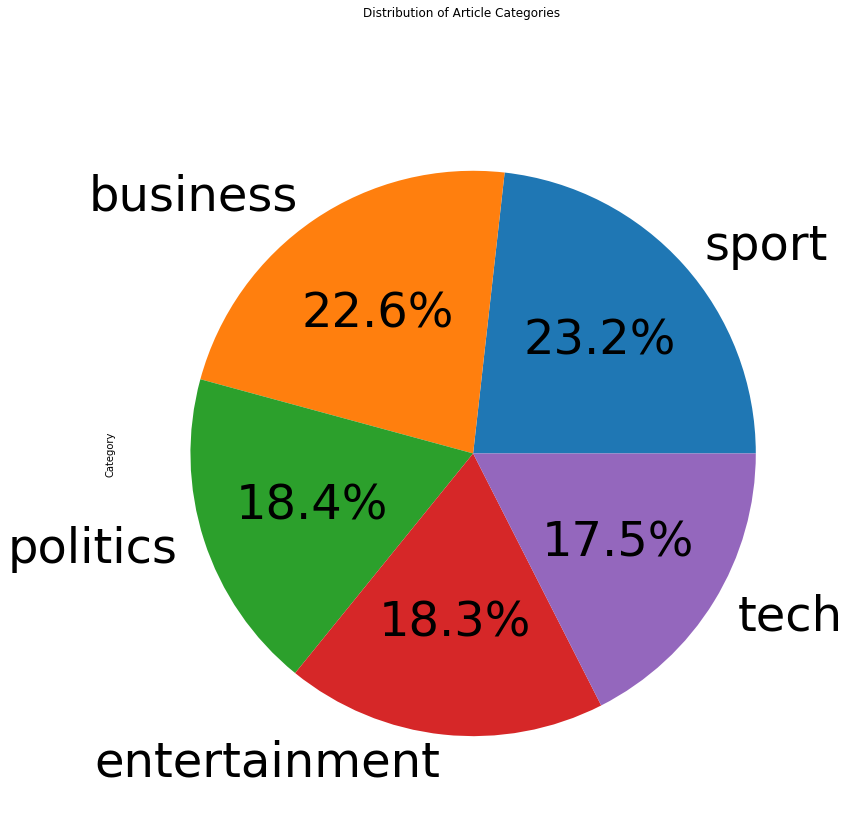

In [24]:
#see distribution of article categories
dist_pie = BBC_train_cat.plot(kind = 'pie',figsize = (13,13),title = "Distribution of Article Categories", 
    autopct='%.1f%%', subplots = 'True',fontsize = 48)
#plt.savefig('Distribution_valid_fraud_ccc.png')

In [25]:
#preview text formats
print(BBC_train.Text[5])

howard  truanted to play snooker  conservative leader michael howard has admitted he used to play truant to spend time with his school friends at a snooker hall.  mr howard said his time at jack s snooker hall in llanelli in the 1950s had not done him  any lasting damage . but he told the times educational supplement that truancy was  very bad  and said  firm action  was needed. mr howard also called for a return to o-levels and more classroom discipline.  mr howard eventually left llanelli grammar school - and the snooker hall - to go to cambridge university. he said:  i don t think it s done me any lasting damage. nor has it made me a snooker world champion.  there might have been some occasions when we left early of an afternoon.   i m just being honest. i think truancy is a very bad thing and that firm action should be taken to deal with it.  another player who has failed to win snooker s world championship - jimmy  the whirlwind   white - has previously admitted missing lessons  i

In [41]:
#lets remove punctuation, numbers, stop words, extra spaces
def cleanup_text(dataframe, text_col):
    #remove punctuation
    dataframe['clean_text'] = dataframe[text_col].apply(lambda item: re.sub(r'[^\w\s]+', '',item))
    #remove numbers
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(r'[0-9]+', '',item))
    #remove stop words
    stop_words = stopwords.words('english')
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: " ".join([x for x in item.split() if x not in stop_words]))
    #remove extra spaces
    dataframe['clean_text'] = dataframe['clean_text'].apply(lambda item: re.sub(' +', ' ', item))

    return dataframe
    

In [68]:
BBC_train = cleanup_text(BBC_train, 'Text')
print(BBC_train.clean_text[5])

howard truanted play snooker conservative leader michael howard admitted used play truant spend time school friends snooker hall mr howard said time jack snooker hall llanelli done lasting damage told times educational supplement truancy bad said firm action needed mr howard also called return olevels classroom discipline mr howard eventually left llanelli grammar school snooker hall go cambridge university said think done lasting damage made snooker world champion might occasions left early afternoon honest think truancy bad thing firm action taken deal another player failed win snooker world championship jimmy whirlwind white previously admitted missing lessons instead spending days smoky halls tony meo another player used spend spare time mr white said loved game atmosphere school went window went started taking time mr howard fellow welshman ray reardon known fellow professionals dracula snooker world championship six times left school work miner terry griffiths like mr howard llan

In [29]:
#now lets tokenize and lemmatizer
lemm = WordNetLemmatizer()

def lemmenatize(text):
    lem = [lemm.lemmatize(item) for item in text] 
    return lem

def tokenize_lemmenatize(dataframe, text_col):
    #tokenize
    dataframe['tockenize'] = dataframe.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    #lemmatize
    dataframe['lemmatize'] = dataframe['tockenize'].apply(lambda item: lemmenatize(item))
    #sort alphabetically
    dataframe['lemmatize'] = dataframe['lemmatize'].apply(lambda item: sorted(item))
    #count number of words in string
    dataframe['num_words'] = dataframe['lemmatize'].apply(lambda strings: len(strings))

    return dataframe

In [69]:
BBC_train = tokenize_lemmenatize(BBC_train, 'clean_text')
print(BBC_train['lemmatize'])

0       [accounting, accounting, accounting, accountin...
1       [activity, analyst, bank, bank, bernd, busines...
2       [absorbed, across, ago, almost, also, also, al...
3       [able, across, activity, advisor, ageing, ago,...
4       [action, action, added, adding, admit, ago, ag...
                              ...                        
1485    [actor, actress, afterwards, although, announc...
1486    [act, act, add, adding, addition, advantage, a...
1487    [added, adding, adding, aimed, also, also, bac...
1488    [according, according, according, added, added...
1489    [across, address, affected, announcing, appear...
Name: lemmatize, Length: 1490, dtype: object


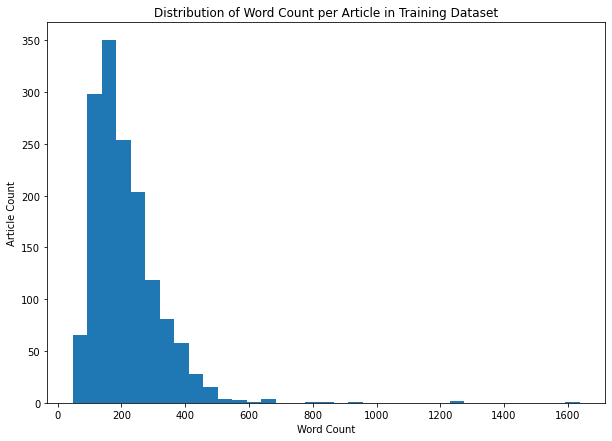

In [33]:
#plot distribution of word count per article
fig, ax = plt.subplots(figsize =(10, 7))
n_bins = 35
ax.hist(BBC_train.num_words, bins = n_bins)

plt.xlabel("Word Count")
plt.ylabel("Article Count")
plt.title('Distribution of Word Count per Article in Training Dataset')

plt.show()
#couple of outliers that may want to be removed so as not to skew model building moving forward (>600?)

In [70]:
#remove outliers from training dataset
print(round((len(BBC_train[BBC_train['num_words'] > 600])/len(BBC_train))*100,2),'% of dataset have > 600 word counts per article')
print("length of full dataset",len(BBC_train))
BBC_train = BBC_train[BBC_train['num_words'] < 600]
#confirm outliers were dropped
print("length of reduced dataset",len(BBC_train))


0.74 % of dataset have > 600 word counts per article
length of full dataset 1490
length of reduced dataset 1479


In [ ]:
#show boxplot of words per article in each category

In [47]:
#function to predict category of article based on factorization
def predict(NMFmatrix):
    #sort values in matrix along each row in ascending order & return indices of values in sorted order
    #print("unsorted",NMFmatrix[5:7])
    sortedNMF = np.argsort(NMFmatrix)
    #print("sorted", sortedNMF[5:7])
    n_predictions, maxValue = sortedNMF.shape
    #print('n_predictions',n_predictions, 'maxValue', maxValue)
    #create 2D list with column index of the highest weight value for each row
    predictions = [[sortedNMF[i][maxValue - 1]] for i in range(n_predictions)]
    #print("predictions",predictions[5:7])
    topics = np.empty(n_predictions, dtype = np.int64)
    #extract single predicted topic(largest column index) for each row
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    #print("topics",topics[5:7])
    return topics

In [48]:
def label_permute_compare(ytdf,yp, n = 5):
    """
    ytdf: Training data
    yp: clustering label prediction output
    Returns best permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.88 
    """
# your code here

    perm = list(it.permutations(range(0,n),n))
    ytdf_lab = ['business', 'tech', 'politics', 'sport', 'entertainment']
    #print(ytdf_lab)

    best_perm = []
    score = 0
    for i in perm:
        dict = {}
        for j in range(len(i)):
            dict[ytdf_lab[j]] = i[j]
        #print(dict)

        testing = pd.DataFrame(ytdf['Category']).replace(dict)

        curr_acc = accuracy_score(testing,yp)
        if curr_acc > score:
            score = curr_acc
            best_perm = i


    return(best_perm, score)

In [71]:
#vectorizer
tfv = TfidfVectorizer(min_df = 0, max_df = 0.85, norm = 'l2', stop_words = 'english')
tfv_tot = tfv.fit_transform(BBC_train['clean_text'])
tfv_train = tfv_tot[:1479,:]

cv = CountVectorizer(min_df = 0, max_df = 0.85, stop_words = 'english')
cv_train= cv.fit_transform(BBC_train['clean_text'])

#model
nmf_model = NMF(n_components = 5, init = 'nndsvd', solver = 'cd',beta_loss = 'frobenius', l1_ratio = 0.5)
nmf_model.fit(tfv_train)

y_train = predict(nmf_model.transform(tfv_train))
label_order, acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', acc, "\nlabel_order", label_order)




accuracy = 0.9161595672751859 
label_order (4, 2, 1, 0, 3)


In [72]:
#testing CV vectorizer & tuning hyper parameters
nmf_cv_mod = NMF(n_components = 5, 
                init = 'nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler', 
                l1_ratio = 0.5,
                random_state = 123)
nmf_cv_mod.fit(cv_train)

y_train = predict(nmf_cv_mod.transform(cv_train))
cv_label_order, cv_acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', cv_acc, "\nlabel_order", cv_label_order)
#able to get to reasonable accuracy But takes longer

accuracy = 0.9296822177146721 
label_order (0, 3, 1, 4, 2)


In [92]:
#tuning TFID hyperparameters
tfv = TfidfVectorizer(min_df = 2, 
                    max_df = 0.95, 
                    norm = 'l2', 
                    stop_words = 'english')
tfv_train= tfv.fit_transform(BBC_train['clean_text'])
#tuing of vectorizer not as impactful as model parameters

nmf_model = NMF(n_components = 5, 
                init = 'nndsvda', 
                solver = 'mu',
                beta_loss = 'kullback-leibler', 
                l1_ratio = 0.5,
                random_state= 123)
nmf_model.fit(tfv_train)

y_train = predict(nmf_model.transform(tfv_train))
label_order, acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', acc, "\nlabel_order", label_order)



In [83]:
#iterate through possible parameters to find best combo
nmf_param_grid = {"init": ["nndsvdar", "nndsvd"],
                  "solver": ["mu"],
                  "beta_loss": ["kullback-leibler"],
                  "alpha_W" : [0, 1.0],
                  "alpha_H" : [0, 0.5, 1.0],
                  "l1_ratio" : [0, 0.5, 1.0]}
records = {k:list() for k, v in nmf_param_grid.items()}
records["accuracy"] = list()
max_nmf_acc, best_nmf_clf = 0, None
for params in ParameterGrid(nmf_param_grid):
    clf = NMF(n_components=5, max_iter=1000, **params).fit(tfv_train, y_train)
    for k, v in params.items():
        records[k].append(v)
    y_train_pred = predict(clf.transform(tfv_train))
    label_order, acc =  label_permute_compare(BBC_train,y_train_pred)
    #acc = np.mean(y_train==y_train_pred)
    records["accuracy"].append(acc)
    if (acc > max_nmf_acc):
        max_nmf_acc, best_nmf_clf = acc, clf

max_nmf_acc, best_nmf_clf

(0.9594320486815415,
 NMF(alpha_H=1.0, alpha_W=0, beta_loss='kullback-leibler', init='nndsvdar',
     l1_ratio=0, max_iter=1000, n_components=5, solver='mu'))

In [84]:
y_train = predict(best_nmf_clf.transform(tfv_train))
label_order, acc =  label_permute_compare(BBC_train,y_train)
print('accuracy =', acc, "\nlabel_order", label_order)

accuracy = 0.9594320486815415 
label_order (4, 2, 1, 0, 3)


In [85]:
#print label assignments
label_dict = {}
cats = ['business', 'tech', 'politics', 'sport', 'entertainment']
for i in range(5):
    label_dict[label_order[i]] = cats[i]

# cv_label_dict = {}
# cats = ['business', 'tech', 'politics', 'sport', 'entertainment']
# for i in range(5):
#     cv_label_dict[cv_label_order[i]] = cats[i]

print(label_dict)#,'\n',cv_label_dict)


{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


In [86]:
#prep test dataset
BBC_test = cleanup_text(BBC_test, 'Text')

#cv_test= cv.fit_transform(BBC_test['clean_text'])
tfv_test= tfv.fit_transform(BBC_test['clean_text'])

#nmf_cv_mod.fit(cv_test)
best_nmf_clf.fit(tfv_test)

#cv_y_test = predict(nmf_cv_mod.transform(cv_test))
y_test = predict(best_nmf_clf.transform(tfv_test))



In [87]:
# #create new dataframe to submit to competition (cv)
# test_pred_cv = pd.DataFrame(columns = ['ArticleId','Category','cv_y'])
# test_pred_cv['ArticleId'] = BBC_test['ArticleId']
# test_pred_cv['cv_y'] = cv_y_test
# test_pred_cv['Category'] = test_pred_cv['cv_y'].map(cv_label_dict)

# test_pred_cv = test_pred_cv.drop('cv_y', axis = 1)
# test_pred_cv.head(10)

,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,tech
7,1479,tech
8,27,politics
9,397,business


In [88]:
#create new dataframe to submit to competition
test_pred = pd.DataFrame(columns = ['ArticleId','Category','y'])
test_pred['ArticleId'] = BBC_test['ArticleId']
test_pred['y'] = y_test
test_pred['Category'] = test_pred['y'].map(label_dict)

test_pred= test_pred.drop('y', axis = 1)
test_pred.head(10)

,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,tech
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,business
9,397,tech


In [89]:
try: 
    test_pred.to_csv('BBCclass_submission.csv', index=False)
    #test_pred_cv.to_csv('BBCclass_submission_cv.csv', index = False)
except: 
    pass